In [7]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
from tqdm import tqdm
import warnings
import os

warnings.filterwarnings("ignore")

In [5]:
def Number_page():
    url = "https://www.bbc.co.uk/search?q=coronavirus&d=news_gnl&seqId=d5de4da0-44fb-11ee-b8b1-9f4fa51ed3c8"
    result_requests = requests.get(url, verify=False)
    doc_soup = BeautifulSoup(result_requests.text, "html.parser")
    div_page = doc_soup.find_all(class_="e1ksme8n3 ssrcss-p733us-PageButtonContainer-StyledNumberedPageButton e1kcrsdk0")
    page_number = int(div_page[-1].string)
    return page_number

page_number = Number_page()
print(page_number)

29


In [6]:
def LinksExtraction(page):
    links = []
    url = f"https://www.bbc.co.uk/search?q=coronavirus&d=news_gnl&seqId=d5de4da0-44fb-11ee-b8b1-9f4fa51ed3c8&page={page}"
    result_requests = requests.get(url, verify=False)
    doc_soup = BeautifulSoup(result_requests.text, "html.parser")
    links_corona = doc_soup.find_all(class_="ssrcss-its5xf-PromoLink exn3ah91")
    for item in links_corona :
        href = item["href"]
        links.append(href)
    return links

In [7]:
links = LinksExtraction(1)
for link in links:
    print(link)

https://www.bbc.co.uk/programmes/p0887sdc
https://www.bbc.co.uk/programmes/w13xtv5f
https://www.bbc.co.uk/programmes/b007zqd0
https://www.bbc.co.uk/news/uk-england-tyne-66187798
https://www.bbc.co.uk/news/uk-51768274
https://www.bbc.co.uk/news/world-europe-jersey-64428923
https://www.bbc.co.uk/news/uk-england-leicestershire-65038607
https://www.bbc.co.uk/news/business-64286126
https://www.bbc.co.uk/bitesize/articles/z6jhhbk
https://www.bbc.co.uk/bitesize/articles/z6vdd6f


In [8]:
def TextExtraction(page):
    links = LinksExtraction(page)
    texts = []
    for url in links :
        text = []
        result_url = requests.get(url, verify=False)
        url_soup = BeautifulSoup(result_url.text, "html.parser")
        data_component= url_soup.find_all("div", {"data-component":"text-block"})
        if len(data_component) == 0:
            continue
        for div_data in data_component :
            if div_data.string == None:
                continue
            text.append(div_data.string)
        texts.append(text)
    return texts
    

In [10]:
texts_result = TextExtraction(2)

In [98]:
print(len(texts_result))

8


In [99]:
for list_text in texts_result[:2] :
    for text in list_text:
        print(text)
    print()
    print("*"*120)
    print()

Government-provided public PCR testing for Covid-19 will stop in Jersey from Monday, with the closure of a testing centre at the airport.
Since 2020, more than 1.1 million tests have been carried out at both the airport and harbour testing centres, the Public Health Department said. 
Officials said the system had played a "vital part in protecting the community". 
Free Lateral Flow Test (LFT) kits remain available to order online. 
Islanders have been advised to do stay at home and do a LFT if they feel unwell. 
If they tested positive, they should stay at home for at least five days and until they had been symptom-free for 48 hours, the government said.
Professor Peter Bradley, director of Public Health, said: "I would like to thank everyone, past and present, who has worked tirelessly over the last few years to deliver this testing programme. They have all been a vital part in protecting the community. 
"Although we are scaling down our response, Covid-19 is still with us and will be

## Extraction de Contenu depuis les Liens et Sauvegarde dans des Fichiers CSV

La finalité de cette fonction est créer un dossier DATA. À l'intérieur de ce répertoire, un dossier est crée pour chaque page. À l'intérieur de ces répertoires spécifiques, plusieurs fichiers CSV sont générés en fonction du nombre de liens identifiés. Chaque fichier est associé avec une page web abordant le COVID-19 et est destiné à stocker son contenu.

In [13]:
def SaveTextData(page) :
    data_dir = os.path.join(os.getcwd(), "DATA")
    if page <= 9 :
        page_dir = os.path.join(data_dir, "PAGE_0{}".format(page))
    else :
        page_dir = os.path.join(data_dir, "PAGE_{}".format(page))
    os.makedirs(page_dir, exist_ok=True)
    
    page_texts = TextExtraction(page)
    i = 1
    for list_text in page_texts :
        file = open(os.path.join(page_dir, "text_{}.csv".format(i)), "w", encoding="utf-8")
        for text in list_text :
            if len(text) == 0:
                continue
            file.write(text)
        file.close()
        i += 1
    return 

In [14]:
for page in tqdm(range(1, page_number + 1)):
    SaveTextData(page=page)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [07:32<00:00, 15.62s/it]


#  Fusionner Tous les Contenus des Fichiers en Un Seul "

In [8]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
list_stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jules\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'les enfant sont'

In [21]:
merge_texts = open(os.path.join(os.getcwd(), "merge_file.csv"), "w", encoding='utf-8')
for page_dir in os.listdir(os.path.join(os.getcwd(), "DATA")) :
    for file_csv in os.listdir(os.path.join(os.getcwd(), "DATA", page_dir)):
        file = open(os.path.join(os.getcwd(), "DATA", page_dir, file_csv), "r", encoding="utf-8")
        #supprimer les ponctuation 
        file_text = re.sub(pattern="[^\w\s]", repl=" ", string=file.read())
        #supprimer tous les chiffres
        file_text = re.sub(pattern="\d+", repl=" ", string=file_text).lower() #mettre tous mots en minuscule
        #supprimer les stopwords
        file_text = " ".join([word for word in file_text.split() if word not in list_stopwords])
        #ajouter le texte sur merge_file.csv
        merge_texts.write(file_text)
        
merge_texts.close()

## Afficher l'Intégralité du Texte

In [39]:
file_merge =  open(os.path.join(os.getcwd(), "merge_file.csv"), "r", encoding='utf-8')
file_merge.read()

'two men sold cocaine street value half million pounds covid lockdown jailed christopher riley right hand man darren johnson sold kg class drug april may northumbria police said riley arrested newcastle airport upon arrival dubai officers infiltrated encrypted messages jailed half years johnson nine years six months admitted drugs offences police spokesman said riley came force attention part international operation targeting organised crime two north shields men also selling large amounts cannabis arrested may police seizing cryptocurrency passwords â cash knuckleduster riley home johnson police described riley trusted lieutenant cannabis worth â home knuckleduster detailed debtors list riley washington terrace johnson frosterley place pleaded guilty conspiracy supply class b drugs appeared newcastle crown court det ch insp marc michael said riley made comfortable living significant sums cash instructing others like johnson get hands dirty selling harmful addictive drugs street dealer

# Compter les Apparitions des Mots avec Apache Spark

In [25]:
import findspark
findspark.init()
import seaborn as sns
import matplotlib.pyplot as plt 

In [3]:
import pyspark
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName("WordCount").getOrCreate()

In [6]:
spark

In [26]:
rdd = spark.sparkContext.textFile("merge_file.csv")

In [27]:
rdd_text = rdd.flatMap(lambda x : x.split(' '))\
            .map(lambda x : (x, 1))\
            .reduceByKey(lambda x, y :  x+y)

columns = ["word", "Count"]
df = spark.createDataFrame(data=rdd_text, schema=columns)

In [29]:
df = df.sort(df.Count.desc())
df.show()

+-----------+-----+
|       word|Count|
+-----------+-----+
|      covid| 1027|
|    ireland|  818|
|   northern|  617|
|coronavirus|  573|
|      total|  518|
|     deaths|  474|
|     health|  454|
|    updated|  412|
|      cases|  398|
|     people|  396|
|       last|  381|
| department|  359|
|   republic|  350|
|     number|  301|
|       said|  293|
|   patients|  289|
|   pandemic|  275|
|   hospital|  259|
|       care|  259|
|   reported|  234|
+-----------+-----+
only showing top 20 rows



In [30]:
df_pandas = df.limit(30).toPandas()

In [31]:
df_pandas.shape

(30, 2)

# Visualisation des 30 Mots les Plus Fréquents 

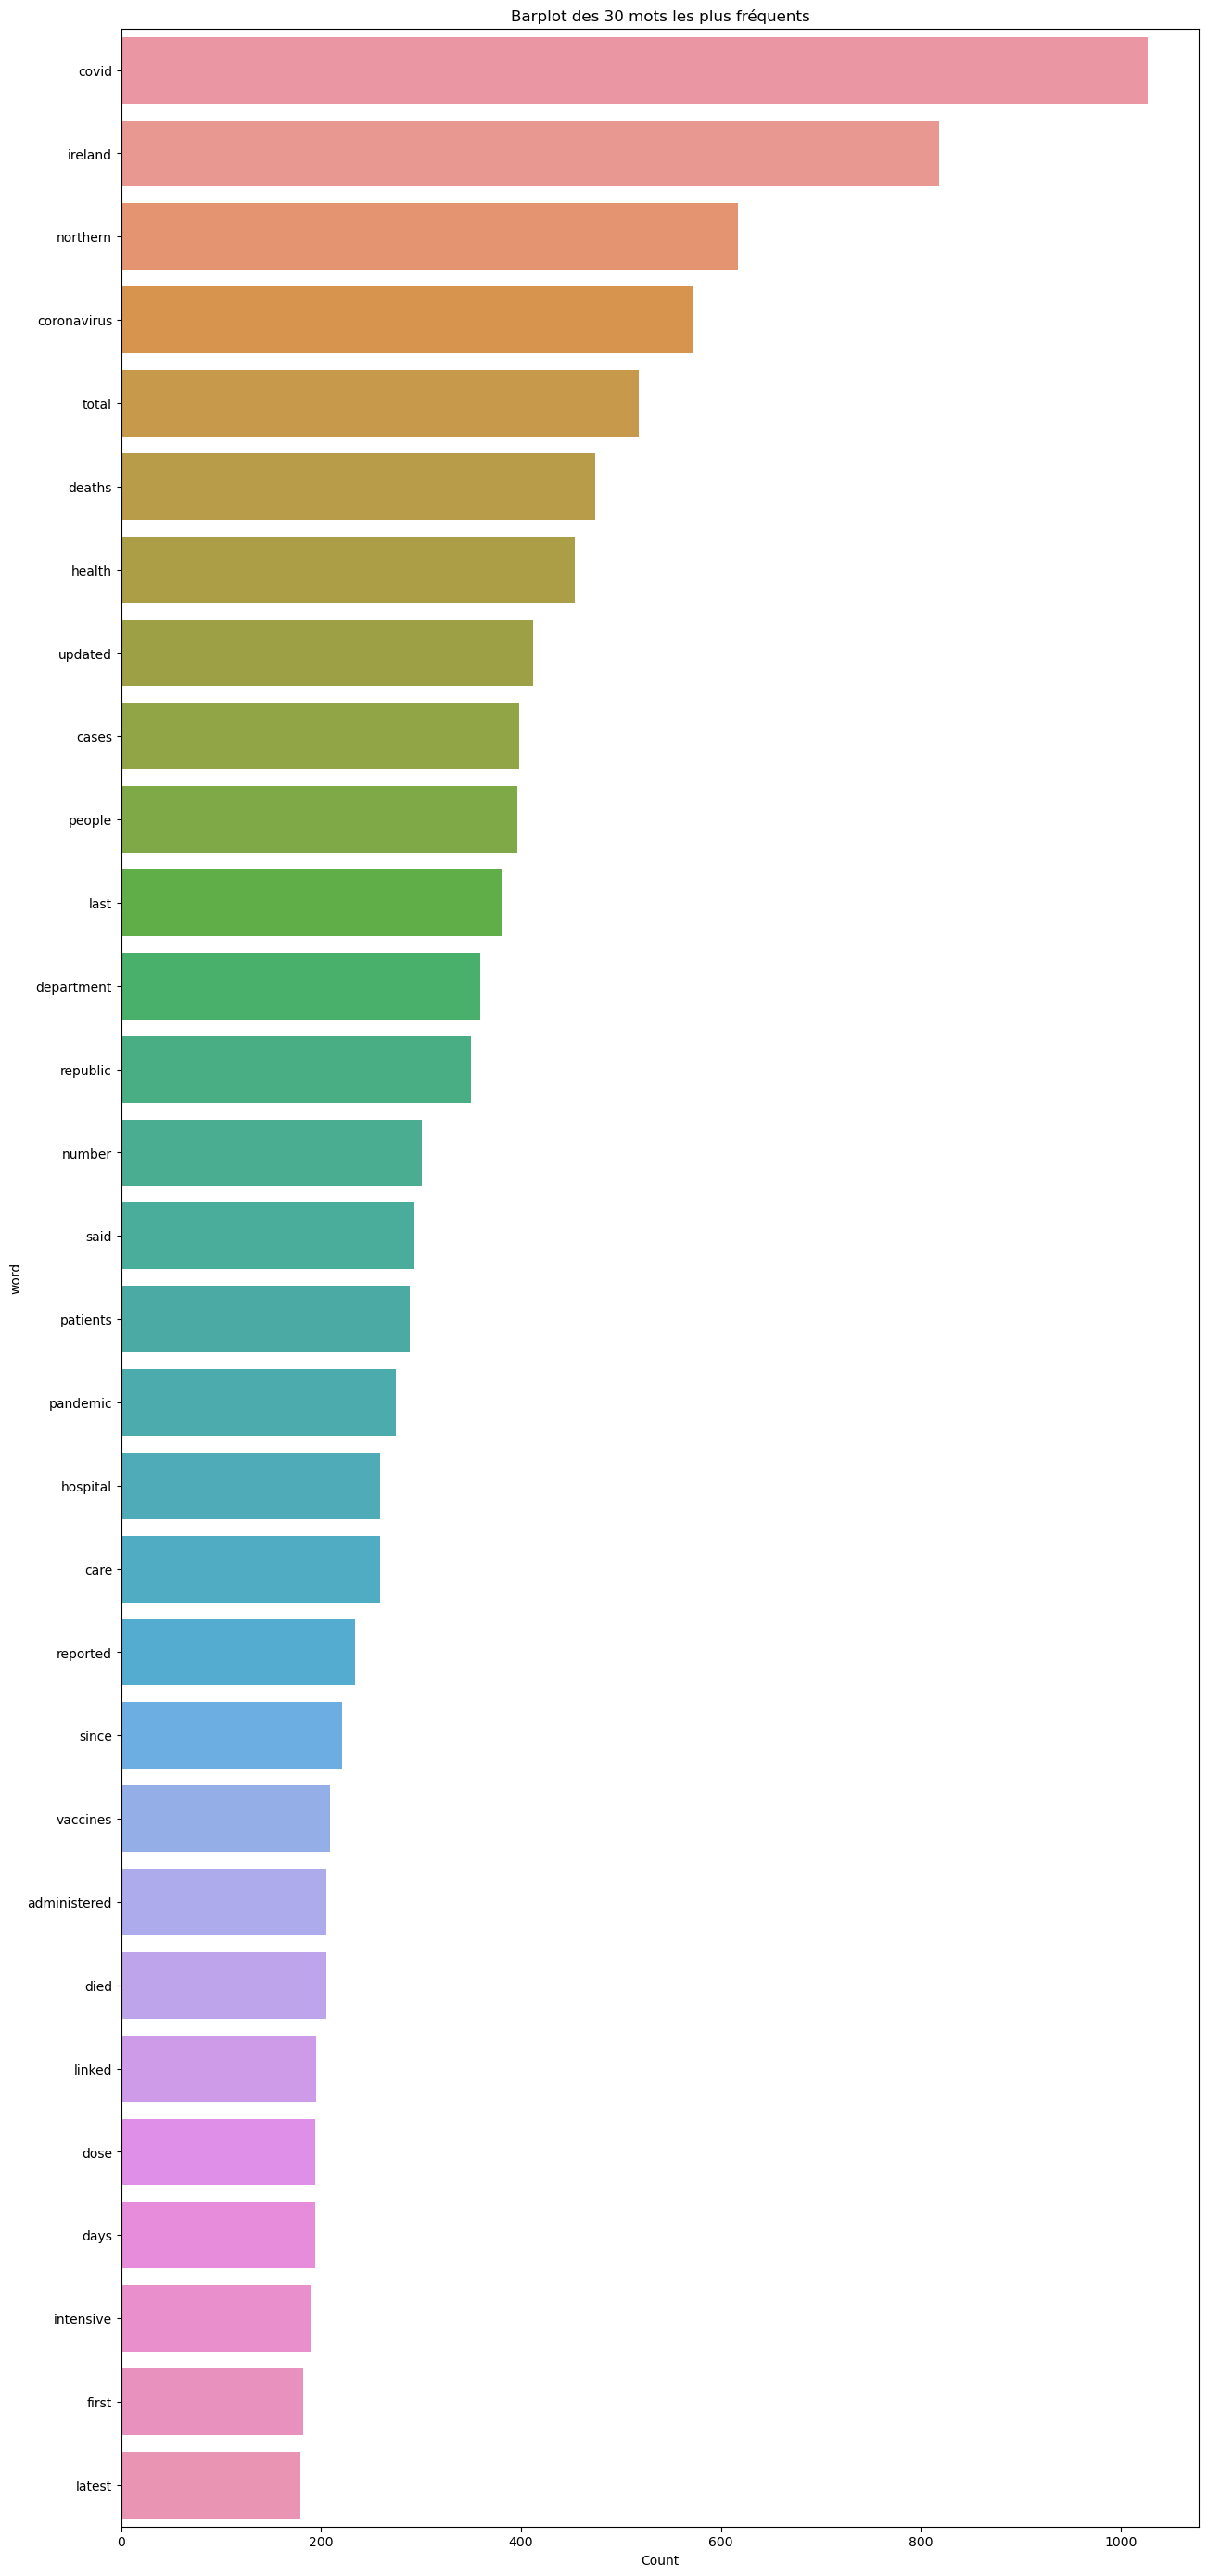

In [38]:
plt.figure(figsize=(15, 35))
sns.barplot(y="word", x="Count", data=df_pandas)
plt.title("Barplot des 30 mots les plus fréquents")
plt.show()